# T5 - Using interventions

Interventions are one of the most critical parts of Covasim. This tutorial shows how to implement standard interventions, as well as how to define your own custom interventions.

## Change beta and clip edges

The most basic intervention in Covasim is "change beta": this changes overall transmission rates on the specified day(s), no questions asked. For example:

Covasim 2.0.2 (2020-02-01) — © 2021 by IDM


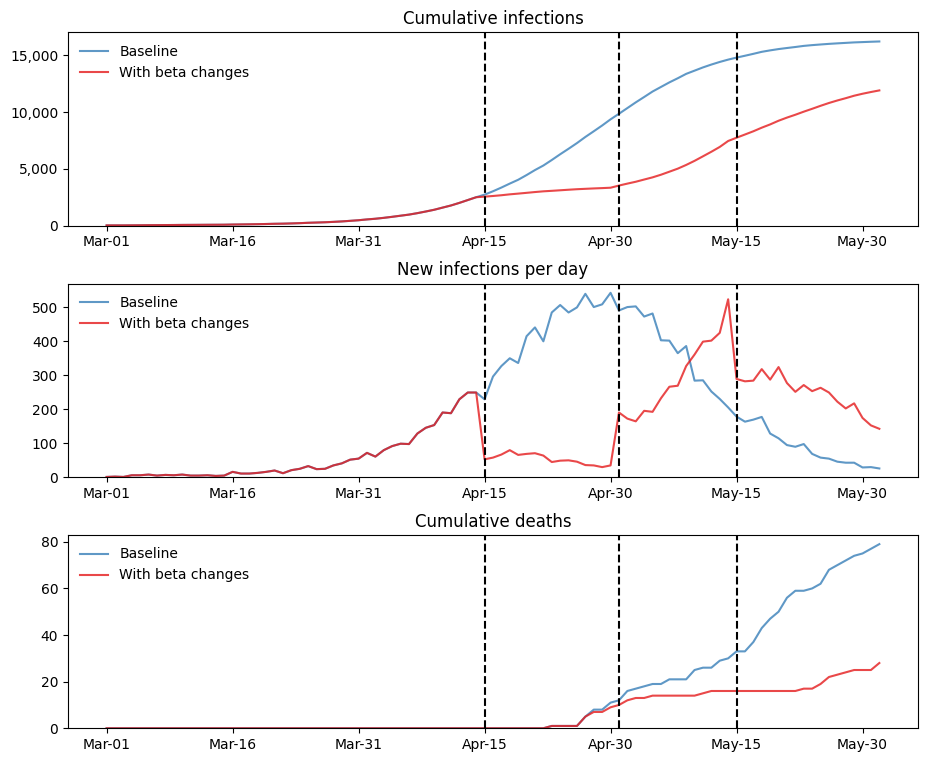

In [1]:
import covasim as cv
cv.options.set(dpi=100, show=False, close=True, verbose=0) # Standard options for Jupyter notebook

# Define baseline parameters and sim
pars = dict(
    start_day = '2020-03-01',
    end_day   = '2020-06-01',
    pop_type  = 'hybrid',
)
orig_sim = cv.Sim(pars, label='Baseline')

# Define sim with change_beta
cb = cv.change_beta(days=['2020-04-15', '2020-05-01', '2020-05-15'], changes=[0.2, 1.5, 0.7])
sim = cv.Sim(pars, interventions=cb, label='With beta changes')

# Run and plot
msim = cv.MultiSim([orig_sim, sim])
msim.run()
msim.plot()

A few things to note here:

* By default, interventions are shown with vertical dashed lines. You can turn this off by passing `do_plot=False` to the intervention.
* Look at the new infections plot (middle) for the clearest illustration of the impact the intervention has.
* Note that like other "parameters", you can either pass interventions to the sim directly or as part of the pars dictionary; the examples below illustrate these options.
* All interventions handle dates automatically, so days can be specified as strings, integer numbers of days from the start of the sim, or datetime objects. You can even mix and match (e.g. `days=[10, '2020-05-05']`), although this is not recommended for obvious reasons!

If your simulation has different layers (discussed in Tutorial 1), you can also define the beta change to only apply to a single layer. For example, an intervention that closed 90% of schools (`'s'`) on September 1st would be written as:

```python
close_schools = cv.change_beta(days='2020-09-01', changes=0.1, layers='s')
```

The "clip edges" intervention works similarly to the "change beta" intervention, with two important distinctions:

1. Whereas beta changes affect the per-contact transmission probability, clip edges change the number of contacts. For example, in the `close_schools` example above, each school-aged child has an unchanged number of contacts (about 20), but 10 times lower probability of infection per contact (about 0.1% per contact per day). If clip edges were used instead, then each child would have unchanged probability of infection per contact (about 1% per contact per day), but 10 times fewer contacts (about 2).
2. While beta changes can be any value (greater or less than 1), as the name implies, clip edges can only *clip* edges, not create new ones. Edges that are clipped are saved and can later be restored, but you can never have a change of greater than 1.0 with clip edges.

<div class="alert alert-success">

Overall, it's best to use `change_beta` for interventions that reduce per-contact risk (e.g., masks), and `clip_edges` for interventions that reduce the number of contacts per person. However, in practice, it tends to make relatively little difference to the simulation results. If in doubt, use `change_beta`.

</div>

## Testing interventions

There are two types of testing interventions in Covasim:

1. `test_num` performs the specified *number* of tests per day;
2. `test_prob` performs testing with the specified *probability*.

Typically, if you have actual data on number of tests, you would use `test_num`; otherwise, you would usually use `test_prob`. For `test_num`, other than the number of tests performed, the main parameter is `symp_prob`, which determines how much more likely someone with (true positive) COVID symptoms is to test than a person who is asymptomatic or uninfected. Higher values of `symp_prob` give more diagnoses per number of tests, since symptomatic people preferentially test. The default value is 100, meaning that on any given day, a person experiencing COVID symptoms is 100 times more likely to test than someone who isn't.

Likewise, `test_prob` also lets you specify the (daily) probability of symptomatic vs. asymptomatic testing. Unlike `test_num`, however, the total number of tests is determined by these probabilities. For example, since symptomatic testing probabilities are usually much higher than asymptomatic, if the epidemic is growing, more people will be symptomatic and thus go to be tested.

<div class="alert alert-success">

Note that test probabilities for `test_prob` are daily probabilities, not total. If you set `symp_prob = 0.3`, this means a person has a 30% chance of testing *per day of symptoms*, meaning that on average they will go to be tested after 2-3 days. Given that symptoms last for up to 8 days, the total probability that they will test at some point during their illness is much higher than the daily probability.

</div>

The example below illustrates (a) `test_num` with data, (b) `test_num` with a fixed number of tests per day, and (c) `test_prob`.

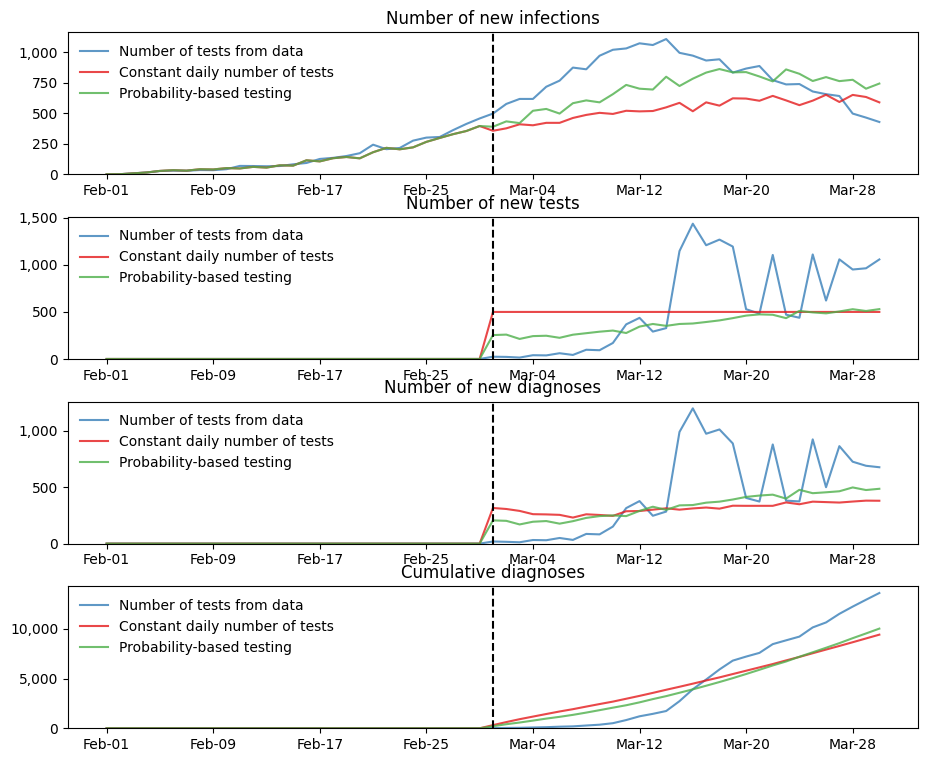

In [2]:
import covasim as cv

# Define the testing interventions
tn_data = cv.test_num('data')
tn_fixed = cv.test_num(daily_tests=500, start_day='2020-03-01')
tp = cv.test_prob(symp_prob=0.2, asymp_prob=0.001, start_day='2020-03-01')

# Define the default parameters
pars = dict(
    pop_size = 50e3,
    pop_infected = 100,
    start_day = '2020-02-01',
    end_day   = '2020-03-30',
)

# Define the simulations
sim1 = cv.Sim(pars, datafile='example_data.csv', interventions=tn_data, label='Number of tests from data')
sim2 = cv.Sim(pars, interventions=tn_fixed, label='Constant daily number of tests')
sim3 = cv.Sim(pars, interventions=tp, label='Probability-based testing')

# Run and plot results
msim = cv.MultiSim([sim1, sim2, sim3])
msim.run()
msim.plot(to_plot=['new_infections', 'new_tests', 'new_diagnoses', 'cum_diagnoses'])

## Contact tracing

Contact tracing is the process of notifying the contacts of a diagnosed positive COVID case and letting them know that they have been exposed, so they can be tested, go into quarantine, or both. Since contact tracing uses diagnosed people to start with, and since people are only diagnosed if they are tested, you **must** include at least one testing intervention in your sim before including contact tracing. The main option for contact tracing is `trace_prob`, the probability that a person in each layer will be traced (usually high for households and lower for other layers). For example:

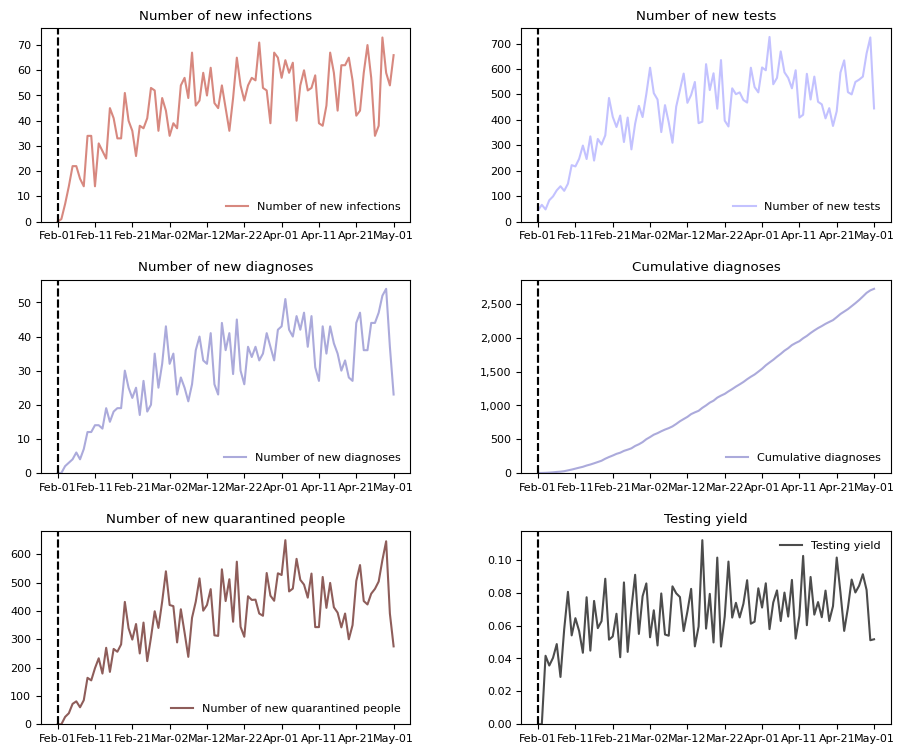

In [3]:
import covasim as cv

# Define the testing and contact tracing interventions
tp = cv.test_prob(symp_prob=0.2, asymp_prob=0.001, symp_quar_prob=1.0, asymp_quar_prob=1.0)
ct = cv.contact_tracing(trace_probs=dict(h=1.0, s=0.5, w=0.5, c=0.3))

# Define the default parameters
pars = dict(
    pop_type      = 'hybrid',
    pop_size      = 50e3,
    pop_infected  = 100,
    start_day     = '2020-02-01',
    end_day       = '2020-05-01',
    interventions = [tp, ct],
)

# Create and run the simulation
sim = cv.Sim(pars)
sim.run()

# Plot the simulation
cv.options.set(font_size=8, show=True) # Make the font size a bit smaller here so the labels don't overlap
sim.plot(to_plot=['new_infections', 'new_tests', 'new_diagnoses', 'cum_diagnoses', 'new_quarantined', 'test_yield'])
cv.options.set(font_size='default', show=False) # Reset to the default value

Since it's assumed that known contacts are placed into quarantine (with efficacy `sim['quar_factor']`), the number of contacts who are successfully traced each day is equal to the number of people newly quarantined (bottom left panel). As is commonly seen using testing and tracing as the only means of epidemic control, these programs stop the epidemic from growing exponentially, but do not bring it to zero.

## Vaccination

Vaccines can do one of two things: they can stop you from becoming infected in the first place (acquisition blocking), or they can stop you from developing symptoms or severe disease once infected (symptom blocking). The Covasim vaccine intervention lets you control both of these options. In its simplest form, a vaccine is like a change beta intervention. For example, this vaccine:

```python
vaccine = cv.vaccine(days=30, prob=1.0, rel_sus=0.3, rel_symp=1.0)
```

is equivalent to this beta change:

```python
cb = cv.change_beta(days=30, changes=0.3)
```

But that's not very realistic. A vaccine given on days 30 and 44 (two weeks later), with efficacy of 50% per dose which accumulates, given to 60% of the population, and which blocks 50% of acquisition and (among those who get infected even so) 90% of symptoms, would look like this:

```python
vaccine = cv.vaccine(days=[30, 44], cumulative=[0.5, 0.5], prob=0.6, rel_sus=0.5, rel_symp=0.1)
```

## Age targeting and other subtargeting

For some interventions, you want them to preferentially apply to some people in the population, e.g. the elderly. For testing and vaccine interventions, this can be done using the `subtarget` argument. Subtargeting is quite flexible in terms of what it accepts, but the easiest approach is usually to define a function to do it. This function must return a dictionary with keys `inds` (which people to subtarget) and `vals` (the values they are subtargeted with). This example shows how to define a 20% transmission-blocking, 94% symptom-blocking vaccine with varying coverage levels by age (for the vaccine intervention, `subtarget` modifies `prob`, the probability of a person being vaccinated) applied on day 20:

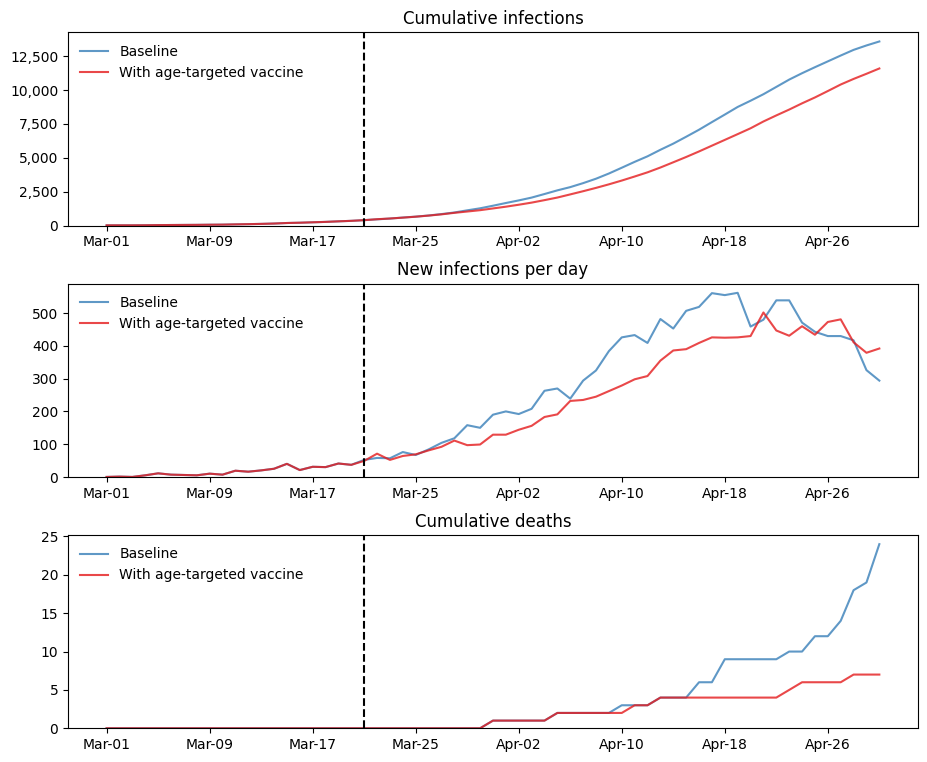

In [4]:
import covasim as cv
import numpy as np

# Define the vaccine subtargeting
def vaccinate_by_age(sim):
    young  = cv.true(sim.people.age < 50) # cv.true() returns indices of people matching this condition, i.e. people under 50
    middle = cv.true((sim.people.age >= 50) * (sim.people.age < 75)) # Multiplication means "and" here
    old    = cv.true(sim.people.age > 75)
    inds = sim.people.uid # Everyone in the population -- equivalent to np.arange(len(sim.people))
    vals = np.ones(len(sim.people)) # Create the array
    vals[young] = 0.1 # 10% probability for people <50
    vals[middle] = 0.5 # 50% probability for people 50-75
    vals[old] = 0.9 # 90% probability for people >75
    output = dict(inds=inds, vals=vals)
    return output

# Define the vaccine
vaccine = cv.vaccine(days=20, rel_sus=0.8, rel_symp=0.06, subtarget=vaccinate_by_age)

# Create, run, and plot the simulations
sim1 = cv.Sim(label='Baseline')
sim2 = cv.Sim(interventions=vaccine, label='With age-targeted vaccine')
msim = cv.MultiSim([sim1, sim2])
msim.run()
msim.plot()

If you have a simple conditional, you can also define subtargeting using a lambda function, e.g. this is a vaccine with 90% probability of being given to people over age 75, and 10% probability of being applied to everyone else (i.e. people under age 75%):
```python
vaccine = cv.vaccine(days=20, prob=0.1, subtarget=dict(inds=lambda sim: cv.true(sim.people.age>50), vals=0.9))
```

However, lambda functions are not known for their easy readability, so their use is discouraged.

## Dynamic parameters

A slightly more advanced intervention is the dynamic parameters intervention. This is not an intervention the same way the others are; instead, it provides a consistent way to modify parameters dynamically. For example, to change the number of imported infections on day 15 from 0 to 100 (representing, say, resuming international travel), and then change back to 0 on day 30:

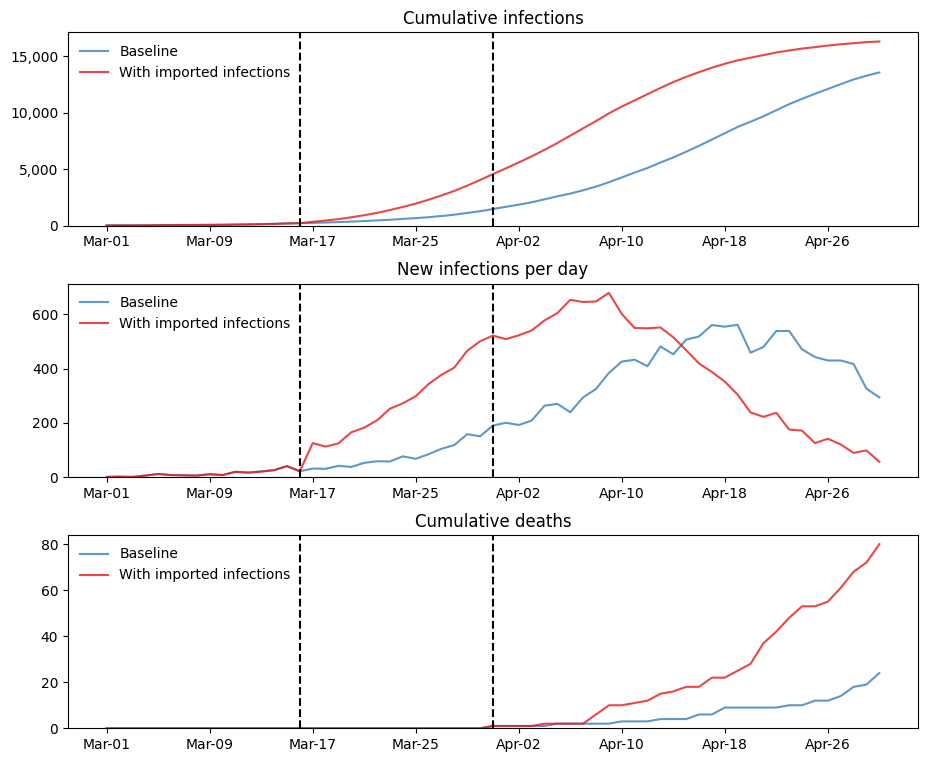

In [5]:
import covasim as cv

# Define the dynamic parameters
imports = cv.dynamic_pars(n_imports=dict(days=[15, 30], vals=[100, 0]))

# Create, run, and plot the simulations
sim1 = cv.Sim(label='Baseline')
sim2 = cv.Sim(interventions=imports, label='With imported infections')
msim = cv.MultiSim([sim1, sim2])
msim.run()
msim.plot()

You can see the sudden jump in new infections when importations are turned on.

## Custom interventions

Covasim also lets you define an arbitrary function or class to act as an intervention instead. If a custom intervention is supplied as a function (as it was in Tutorial 1 as well), then it receives the `sim` object as its only argument, and is called on each timestep. It can perform arbitrary manipulations to the sim object, such as changing parameters, modifying state, etc.

This example reimplements the dynamic parameters example above, except using a hard-coded custom intervention:

In [6]:
def dynamic_imports(sim):
    if sim.t == 15:
        sim['n_imports'] = 100
    elif sim.t == 30:
        sim['n_imports'] = 0
    return

sim = cv.Sim(interventions=dynamic_imports)

However, function-based interventions only take you so far. We saw in Tutorial 1 how you could define a simple "protect the elderly" intervention with just a few lines of code. This example explains how to create an intervention object that does much the same thing, but is more fully-featured because it uses the `Intervention` class.

In [7]:
import numpy as np
import pylab as pl
import covasim as cv

class protect_elderly(cv.Intervention):

    def __init__(self, start_day=None, end_day=None, age_cutoff=70, rel_sus=0.0, *args, **kwargs):
        super().__init__(**kwargs) # This line must be included
        self._store_args() # So must this one
        self.start_day   = start_day
        self.end_day     = end_day
        self.age_cutoff  = age_cutoff
        self.rel_sus     = rel_sus
        return

    def initialize(self, sim):
        self.start_day  = sim.day(self.start_day)
        self.end_day    = sim.day(self.end_day)
        self.days       = [self.start_day, self.end_day]
        self.elderly    = sim.people.age > self.age_cutoff # Find the elderly people here
        self.exposed    = np.zeros(sim.npts) # Initialize results
        self.tvec       = sim.tvec # Copy the time vector into this intervention
        return

    def apply(self, sim):
        self.exposed[sim.t] = sim.people.exposed[self.elderly].sum()

        # Start the intervention
        if sim.t == self.start_day:
            sim.people.rel_sus[self.elderly] = self.rel_sus

        # End the intervention
        elif sim.t == self.end_day:
            sim.people.rel_sus[self.elderly] = 1.0

        return

    def plot(self):
        pl.figure()
        pl.plot(self.tvec, self.exposed)
        pl.xlabel('Day')
        pl.ylabel('Number infected')
        pl.title('Number of elderly people with active COVID')
        return

While this example is fairly long, hopefully it's fairly straightforward:

- **__init__()** just does what init always does; it's needed to create the class instance. For interventions, it's usually used to store keyword arguments and perform some basic initialization (the first two lines).
- **initialize()** is similar to init, with the difference that it's invoked when the *sim* itself is initialized. It receives the sim as an input argument. This means you can use it to do a fairly powerful things. Here, since `sim.people` already exists, we can calculate up-front who the elderly are so we don't have to do it on every timestep.
- **apply()** is the crux of the intervention. It's run on every timestep of the model, and also receives `sim` as an input. You almost always use `sim.t` to get the current timestep, here to turn the intervention on and off. But as this example shows, its real power is that it can make direct modifications to the sim itself (`sim.people.rel_sus[self.elderly] = self.rel_sus`). It can also perform calculations and store data in itself, as shown here with `self.exposed` (although in general, analyzers are better for this, since they happen at the end of the timestep, while interventions happen in the middle).
- **plot()** is a custom method that shows a plot of the data gathered during the sim. Again, it's usually better to use analyzers for this, but for something simple like this it's fine to double-dip and use an intervention.

Here is what this custom intervention looks like in action. Note how it automatically shows when the intervention starts and stops (with vertical dashed lines).

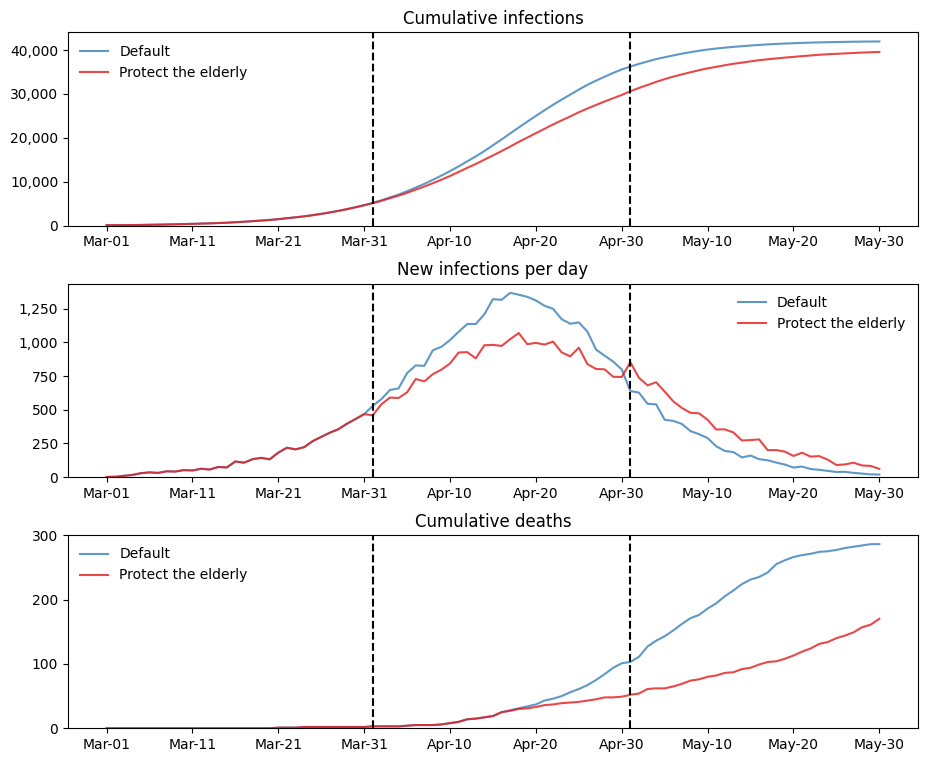

In [8]:
# Define and run the baseline simulation
pars = dict(
    pop_size = 50e3,
    pop_infected = 100,
    n_days = 90,
    verbose = 0,
)
orig_sim = cv.Sim(pars, label='Default')

# Define the intervention and the scenario sim
protect = protect_elderly(start_day='2020-04-01', end_day='2020-05-01', rel_sus=0.1) # Create intervention
sim = cv.Sim(pars, interventions=protect, label='Protect the elderly')

# Run and plot
msim = cv.MultiSim([orig_sim, sim])
msim.run()
msim.plot()

Because we collected information in the intervention itself, we can also plot that:

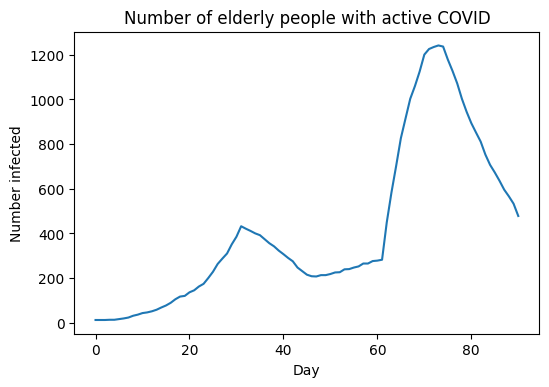

In [9]:
# Plot intervention
protect = msim.sims[1].get_intervention(protect_elderly) # Find intervention by type
protect.plot()